In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz

import scipy.stats
import scipy.optimize
from scipy.signal import find_peaks

%pylab inline

from lmfit import minimize, Parameters, Model, fit_report

Populating the interactive namespace from numpy and matplotlib


In [2]:
def gauss(x, mu, sigma, k):
    return k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

#def breit_vigner4(x, M, w,  G1):
#    a = M/(2*np.pi*G1)
#    b = 1 + np.square(2*(x-w)/G1)
#    return np.round(a/b, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def QFC_back4(x, E_qf, N_0):
    W = 22
    T = 100
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

In [3]:
def prepare_data(x_data_out, dataframe0_4, dataframeIAS, dataframe4_28, noIAS=False, distance=60):
    if noIAS == False:
        beginning = dataframe4_28[((dataframe4_28['x']<8.1))]
        middle = dataframeIAS[((dataframeIAS['x']>8.1) & (dataframeIAS['x']<8.65))]
        ending = dataframe4_28[((dataframe4_28['x']>8.65))]
        data = dataframe0_4.append(beginning).append(middle).append(ending)
    else: 
        data = dataframe0_4.append(dataframe4_28)
    
    x_data = np.linspace(0,28,len(data['x'].values))
    y_data = np.interp(x_data, data['x'].values, data['y'].values)
    
    peaks, _ = sc.signal.find_peaks(-y_data+30, distance=distance)
    
    #y_data2 doesn't contain IAS
    y_data2 = np.interp(x_data, x_data[peaks], y_data[peaks])
    
    #temp1 - raw data, temp2 - smothed data with no IAS
    temp1 = pd.DataFrame({'x':x_data, 'y':y_data})
    temp2 = pd.DataFrame({'x':x_data, 'y':y_data2})
    
    #data3 - smothed data with IAS
    data3 = temp2[(temp2['x']<8.1)].append(temp1[((temp1['x']>8.17) & (temp1['x']<8.65))]).append(temp2[(temp2['x']>8.65)])
    
    y_data_out = np.interp(x_data_out, data3['x'].values, data3['y'].values)
    return temp1, y_data_out

(0, 10)

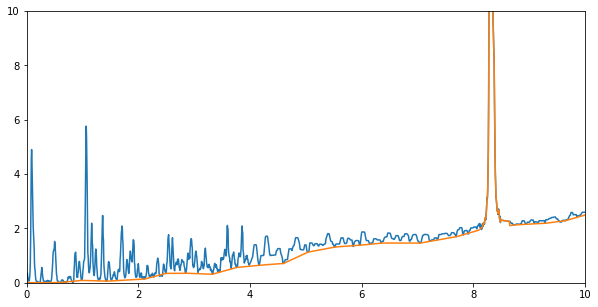

In [5]:
data_to_fit_x = np.linspace(0,28, 4000)

red_0_4 = pd.read_csv('../B(GT) peaks processing/recognition/red data/0_4_red.csv', 
                      sep='\t', decimal=',')
redIAS = pd.read_csv('../B(GT) peaks processing/recognition/red data/IAS_red.csv', 
                      sep='\t', decimal=',')
red_4_28 = pd.read_csv('../B(GT) peaks processing/recognition/red data/4_28_red.csv', 
                      sep='\t', decimal=',')

red_full, red_smothed = prepare_data(data_to_fit_x, red_0_4, redIAS, red_4_28)

plt.figure(figsize=(10,5))
plt.plot(red_full['x'].values, red_full['y'].values)
plt.plot(data_to_fit_x, red_smothed)
plt.xlim(0,10)
plt.ylim(0,10)

Text(0.5,0,'E, MeV')

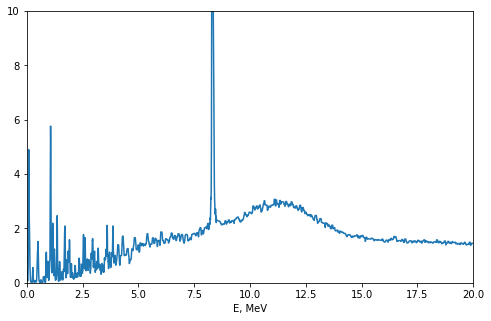

In [83]:
plt.figure(figsize=(8,5))
plt.plot(red_full['x'].values, red_full['y'].values)
plt.xlim(0,20)
plt.ylim(0,10)
plt.xlabel('E, MeV')

In [6]:
data_to_fit_y = np.array(red_smothed)

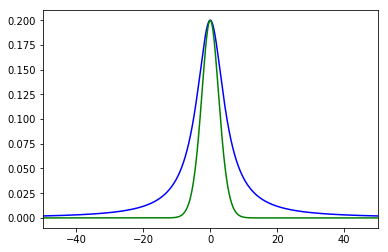

In [88]:
x=np.arange(-1000,1000,0.01)
G=5
M=1
w=0
#y = 1-np.exp(-(x/G)**2)
y1 = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
y11 = M * (G**1) * (np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)

y2 = M * (G**1) / ((x - w)**2 + (G**2)/1)
y3 = 1 - np.exp(-(x/G)**2)
y4 = x*np.exp(-(x/G)**2)
#plt.plot(x,y1)
plt.plot(x,y2, c='b')
plt.plot(x,y11, c='g')
plt.xlim(-50,50)
#plt.ylim(0,0.5)
plt.show()
             

In [71]:
trapz(y2, x), trapz(y1, x)

(3.1215932202251104, 1.7782997985783755)